In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid")

clutter_data = pd.read_csv('../../data/clean/orbital_clutter_cleaned.csv')

print(f"Loaded {len(clutter_data)} objects.")
print(clutter_data['category'].value_counts())
clutter_data.head(10)

Loaded 32695 objects.
category
Debris                12662
Inactive Satellite    11978
Active Satellite       5610
Rocket Body            2397
Unknown                  48
Name: count, dtype: int64


,object_name,object_id,norad_id,object_type,ops_status,owner,launch_date,launch_site,decay_date,period_minutes,...,perigee_km,rcs,data_status,orbit_center,orbit_type,orbit_class,users,purpose,source,category
0,VANGUARD 1,1958-002B,5,PAY,NaN,US,1958-03-17,AFETR,NaN,132.60,...,651.0,0.1220,NaN,EA,ORB,MEO,NaN,NaN,left_only,Inactive Satellite
1,VANGUARD 2,1959-001A,11,PAY,NaN,US,1959-02-17,AFETR,NaN,120.99,...,552.0,0.3931,NaN,EA,ORB,LEO,NaN,NaN,left_only,Inactive Satellite
2,VANGUARD R/B,1959-001B,12,R/B,NaN,US,1959-02-17,AFETR,NaN,125.38,...,553.0,0.5266,NaN,EA,ORB,LEO,NaN,NaN,left_only,Rocket Body
3,VANGUARD R/B,1958-002A,16,R/B,NaN,US,1958-03-17,AFETR,NaN,137.20,...,651.0,0.2282,NaN,EA,ORB,MEO,NaN,NaN,left_only,Rocket Body
4,VANGUARD 3,1959-007A,20,PAY,NaN,US,1959-09-18,AFETR,NaN,123.95,...,506.0,0.6412,NaN,EA,ORB,LEO,NaN,NaN,left_only,Inactive Satellite
5,EXPLORER 7,1959-009A,22,PAY,NaN,US,1959-10-13,AFETR,NaN,94.45,...,434.0,0.5003,NaN,EA,ORB,LEO,NaN,NaN,left_only,Inactive Satellite
6,PIONEER 5,1960-001A,27,PAY,NaN,US,1960-03-11,AFETR,NaN,NaN,...,NaN,0.0008,NEA,SU,ORB,Unknown,NaN,NaN,left_only,Inactive Satellite
7,TIROS 1,1960-002B,29,PAY,-,US,1960-04-01,AFETR,NaN,97.40,...,618.0,0.8030,NaN,EA,ORB,LEO,NaN,NaN,left_only,Inactive Satellite
8,TRANSIT 2A,1960-007A,45,PAY,NaN,US,1960-06-22,AFETR,NaN,100.29,...,589.0,0.4299,NaN,EA,ORB,LEO,NaN,NaN,left_only,Inactive Satellite
9,SOLRAD 1 (GREB),1960-007B,46,PAY,NaN,US,1960-06-22,AFETR,NaN,99.00,...,576.0,0.3501,NaN,EA,ORB,LEO,NaN,NaN,left_only,Inactive Satellite


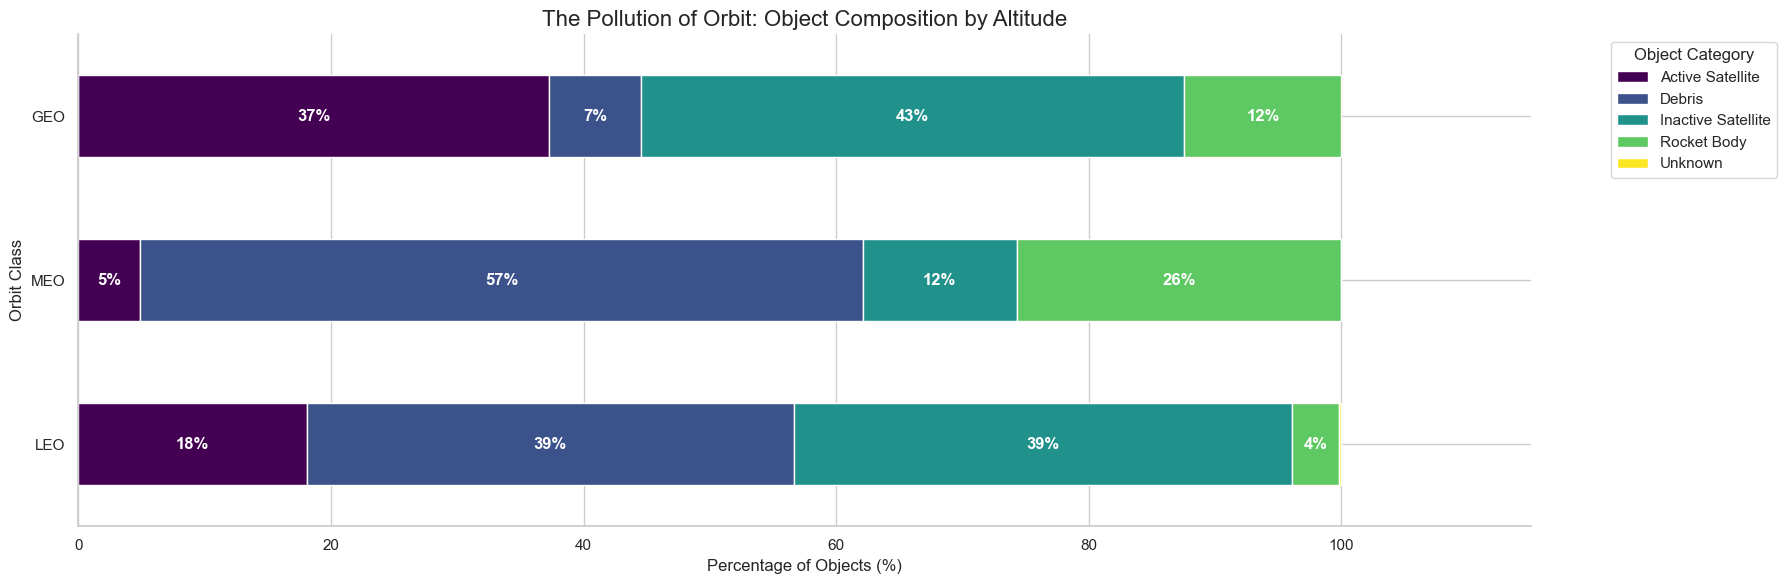

In [2]:
# Create the crosstab (Orbit Class vs Category)
orbit_composition = pd.crosstab(
    clutter_data['orbit_class'], 
    clutter_data['category'], 
    normalize='index'
) * 100 # Multiply by 100 to convert to percentage.

# Filter off elliptical and unknown orbits.
orbit_composition = orbit_composition.loc[['LEO', 'MEO', 'GEO']]

# Plot
ax = orbit_composition.plot(
    kind='barh', 
    stacked=True, 
    figsize=(18, 6), 
    colormap='viridis'
)

plt.title('The Pollution of Orbit: Object Composition by Altitude', fontsize=16)
plt.xlabel('Percentage of Objects (%)')
plt.ylabel('Orbit Class')

plt.legend(title='Object Category', bbox_to_anchor=(1.05, 1), loc='upper left')

for c in ax.containers:
    # Create custom labels: Only show text if the value is > 0 because the 0 is getting smashed at the end of the visualization.
    # v.get_width() gets the size of the bar segment
    labels = [f'{v.get_width():.0f}%' if v.get_width() > 1 else '' for v in c]
    
    # Apply the custom labels
    ax.bar_label(c, labels=labels, label_type='center', color='white', fontweight='bold')

plt.xlim(0, 115) # Extends the x-axis to 115% to make room for labels

sns.despine()
plt.tight_layout()
plt.show()

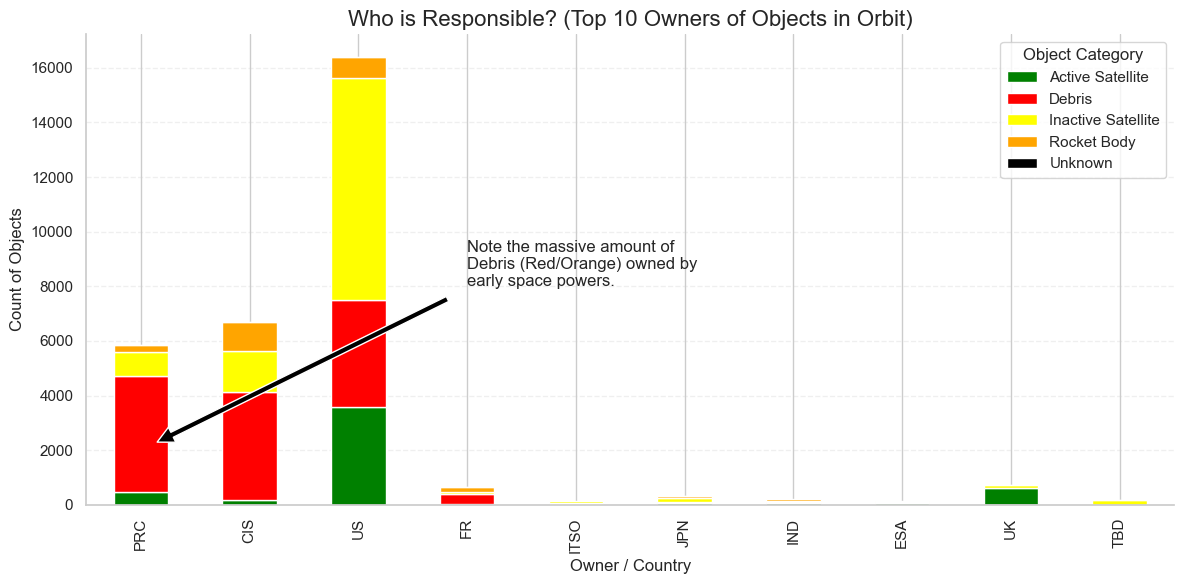

In [3]:
# who are the top 10 contributors to the debris
top_contributors_list = clutter_data['owner'].value_counts().head(10).index

# 2. Filter the main dataset to only include these top 10
top_contributors_data = clutter_data[clutter_data['owner'].isin(top_contributors_list)]

# 3. Create the Crosstab (Owner vs. Category)
contributor_breakdown = pd.crosstab(
    top_contributors_data['owner'], 
    top_contributors_data['category']
)

# Sort by total count so the biggest contributor is on the left
contributor_breakdown = contributor_breakdown.sort_values(
    by=['Debris', 'Rocket Body', 'Inactive Satellite', 'Active Satellite', 'Unknown'], 
    ascending=False
)

color_map = {
  'Debris': 'red',
  'Rocket Body': 'orange',
  'Inactive Satellite': 'yellow',
  'Active Satellite': 'green',
  'Unknown': 'black' 
}

column_colors = [color_map.get(col, 'black') for col in contributor_breakdown.columns]

ax = contributor_breakdown.plot(
    kind='bar', 
    stacked=True, 
    figsize=(12, 6), 
    color=column_colors
)

plt.title('Who is Responsible? (Top 10 Owners of Objects in Orbit)', fontsize=16)
plt.ylabel('Count of Objects')
plt.xlabel('Owner / Country')
plt.legend(title='Object Category')
plt.grid(axis='y', linestyle='--', alpha=0.3)

# Add a text annotation to highlight the "Old Space" trend
plt.annotate('Note the massive amount of \nDebris (Red/Orange) owned by \nearly space powers.', 
             xy=(0, 2000), 
             xytext=(3, 8000),
             arrowprops=dict(facecolor='black', shrink=0.05))

sns.despine()
plt.tight_layout()
plt.show()

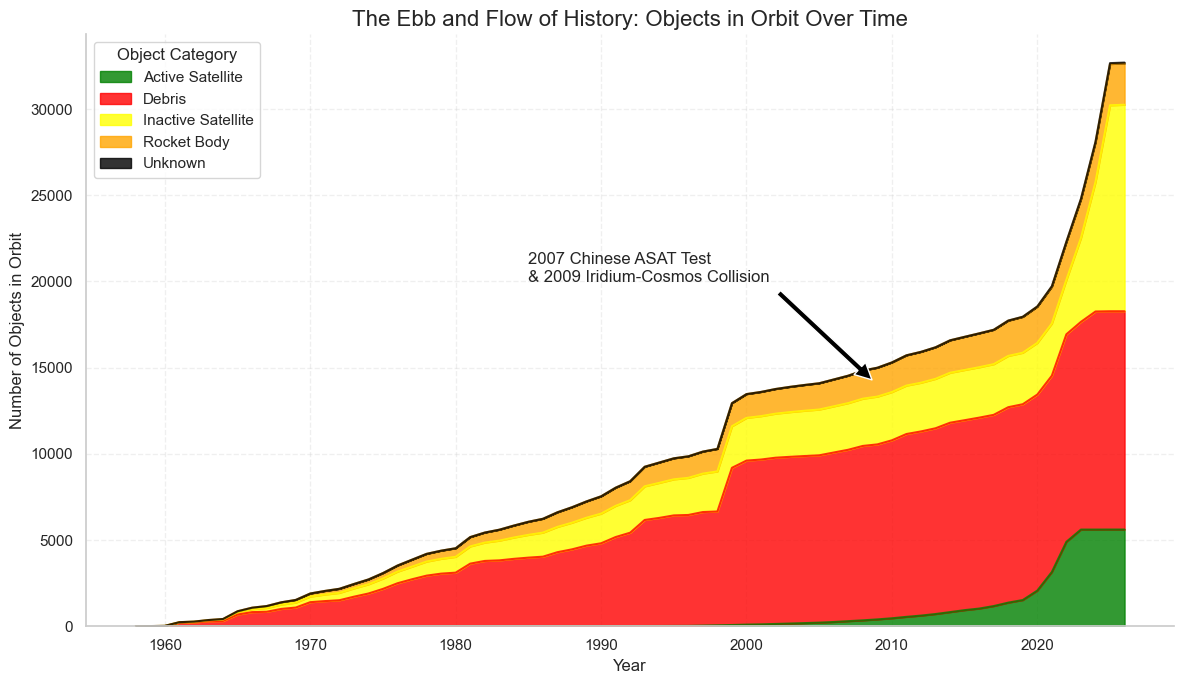

In [4]:
clutter_data['launch_date'] = pd.to_datetime(clutter_data['launch_date'], errors='coerce')
clutter_data['decay_date'] = pd.to_datetime(clutter_data['decay_date'], errors='coerce')

clutter_data['launch_year'] = clutter_data['launch_date'].dt.year
clutter_data['decay_year'] = clutter_data['decay_date'].dt.year

# count up all of the number of objects launched into splace, +1 for each.
launches = clutter_data[['launch_year', 'category']].copy()
launches['change'] = 1
launches.rename(columns={'launch_year': 'year'}, inplace=True)

# count up all of the number of ojects that have decayed from orbit, which were once launched into splace, -1 for each.
decays = clutter_data.dropna(subset=['decay_year'])[['decay_year', 'category']].copy()
decays['change'] = -1
decays.rename(columns={'decay_year': 'year'}, inplace=True)

# Now we stack them to create a list of every time something was launched or dacayed in space.
timeline = pd.concat([launches, decays])

# collect and sum up all entries for the same year.
annual_changes = timeline.groupby(['year', 'category'])['change'].sum().unstack(fill_value=0) # NaN/nill/None replaced with 0 so math can be done on the value.

# annual_changes basically tells the net shipments for the year ( in 2026 +500 items arrived).
# cumsum() tells you the total inventory currently sitting in the warehouse by adding that +500 to everything that was already there from previous years.
objects_in_orbit = annual_changes.cumsum()

current_year = pd.Timestamp.now().year

# objects_in_orbit.loc[1957:current_year] will successfully select all rows from the start label 1957 through and including the end label current_year
objects_in_orbit = objects_in_orbit.loc[1957:current_year]

color_map = {
  'Debris': 'red',
  'Rocket Body': 'orange',
  'Inactive Satellite': 'yellow',
  'Active Satellite': 'green',
  'Unknown': 'black' 
}

# get the color from the corresponding color map for each color.  Return black if not found.
column_colors = [color_map.get(col, 'black') for col in contributor_breakdown.columns]

ax = objects_in_orbit.plot(
    kind='area', 
    stacked=True, 
    figsize=(12, 7),
    color=column_colors, # substitue our colors
    alpha=0.8
)

plt.title('The Ebb and Flow of History: Objects in Orbit Over Time', fontsize=16)
plt.ylabel('Number of Objects in Orbit')
plt.xlabel('Year')
plt.grid(True, linestyle='--', alpha=0.3)
plt.legend(title='Object Category', loc='upper left')

# annotation that shows where in 2007 china blew up one of its own sats, creating tons of debris.
# annotation that shows where in 2009 a dead russian satellite collided with an active, working US Iridium Satellite and also
# created a cloud of debris.
plt.annotate('2007 Chinese ASAT Test \n& 2009 Iridium-Cosmos Collision', 
             xy=(2009, 14000), 
             xytext=(1985, 20000),
             arrowprops=dict(facecolor='black', shrink=0.05))

sns.despine() # remove top and right side splines, looks cleaner/more professional

# automatically adjusts the subplot parameters (like padding) so that elements such as tick labels, axis labels, 
# and titles do not overlap and generally fit within the figure area
plt.tight_layout() 

plt.show()